<img src='./images/LogoWekeo.png' align='left' width='17%'></img>
<img src="./images/Flompy_logo_text.png" align='right' width='30%'/>

**Authors:**  Olympia Gounari, Alexandros Falagas, Kleanthis Karamvasis <br>
**Copyright:** 2021-2022 Kleanthis Karamvasis <br>
**License:** GPLv3

<div class="alert alert-block alert-success">
<h3>FLOODWATER MAPPING & EXTRACTION OF FLOOD-AFFECTED AGRICULTURAL FIELDS</h3></div>

# NOTEBOOK INTRODUCTION

### Data used

| Product Description | Dataset ID | WEkEO metadata |
|:--------------------:|:-----------------:|:-----------------:|
| ERA5 | EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3AREANALYSIS_ERA5_SINGLE_LEVELS" target="_blank">link</a> |
| Sentinel-1 GRD | EO:ESA:DAT:SENTINEL-1:SAR | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AESA%3ADAT%3ASENTINEL-1%3ASAR" target="_blank">link</a> |
| Sentinel-2 | EO:ESA:DAT:SENTINEL-2:MSI | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AESA%3ADAT%3ASENTINEL-2%3AMSI" target="_blank">link</a> |

### Learning outcomes
At the end of this notebook you will be able to:
* Identify flooded agricultural regions
* Identify delineated flood-affected fields
* Identify cultivated and non-cultivated flood-affected fields

<div class="alert alert-danger" role="alert">

Be aware that the estimated run time of the notebook is ~ 30 min

</div>

### Outline

The FLOMPY - <b>FLOod Mapping PYthon toolbox</b> is a free and open-source python toolbox for mapping of floodwater. FLOMPY requires a specified time of interest related to the flood event and corresponding geographical boundaries and generates:
- <b>Floodwater map</b>
- <b>Cultivated and non-cultivated delineated flood-affected fields</b>

Floods are considered the second gravest disaster for the agricultural sector. The increasing intensity and the frequency of flood events can result to significant yield losses. In the present notebook we present a methodological pipeline with the following steps:
1. Extraction of flooded area based on change detection approach using multitemporal Sentinel-1 intensity observations and precipitation data (ERA5 model). More info can be found at [1].
2. Delineation of agricultural fields by combining results from a classical edge detection filtering approach on multitemporal Sentinel-2 data [2] and a U-Net deep learning architecture [3].
3. Characterization of agricultural field to cultivated and non-cultivated based on their temporal behaviour based on multispectral Sentinel-2 data [4].

We believe that the produced maps with delineated flood-affected agricultural fields can be helpful for governments, insurers and disaster response agencies to improve flood risk assessment, relief targeting, and ultimately to protect climate-vulnerable communities from floods. 

References:

<font size="1">
    
[1] Karamvasis K, Karathanassi V. FLOMPY: An Open-Source Toolbox for Floodwater Mapping Using Sentinel-1 Intensity Time Series. Water. 2021; 13(21):2943. [link](https://doi.org/10.3390/w13212943)
    
[2] Yan L, Roy D.P. Automated crop field extraction from multi-temporal Web Enabled Landsat Data. Remote Sensing of Environment. 2014; 144. [link](https://doi.org/10.1016/j.rse.2014.01.006)

[3] Floor S. et. al. Automatic Delineation of Agricultural Fields from Sentinel-2 Images. [link](https://github.com/resingm/field-boundary-delineation)

[4] Gounari 0., Falagas A., Karamvasis K., Tsironis V., Karathanassi V., Karantzalos K.: Floodwater Mapping & Extraction of Flood-Affected Agricultural Fields. Living Planet Symposium Bonn 23-27 May 2022. [link](https://drive.google.com/file/d/1HiGkep3wx45gAQT6Kq34CdECMpQc8GUV/view?usp=sharing)
</font>


<div class="alert alert-info" role="alert">
    
## <a id='TOC_TOP'></a>Contents

</div>
    
[1. Installation Notes](#section1)

[2. Estimation of Flooded Agricultural Area](#section2)

[3. Estimation of Cultivated and Non-Cultivated Delineated Flood-Affected Fields](#section3)

[4. Interactive Plotting](#section4)

<hr>

Our project uses Sentinel-1, digital elevation model and total precipitation ERA5 dataset to detect a flooded agricultural area.

Sentinel-2 and spectral indices, like NDVI, are used to delineate flood-affected agricultural field boundaries and then characterize them as cultivated or not-cultivated during the defined temporal period.

The final product is an interactive map depicting **flooded area**, **flooded agricultural fields** and our **estimation concerning their damage** (cultivated or not-cultivated).

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Installation Notes
[Back to top](#TOC_TOP)

</div>


### <a id='search_download'></a>1.1 Setting up FLOMPY Environment

To install FLOMPY software and the required dependencies go to:

1. `$cd FLOMPY/WEkEO`

2. `$chmod +x installation.sh && ./installation.sh`

<div class="alert alert-danger" role="alert">

After the installation completes, **restart current kernel (`Kernel->Restart Kernel`) of this notebook**.
    
</div>

### <a id='search_download'></a>1.2 Provide WEkEO HDA API Credentials
Fill your WEKEO **username** and your **password** in the following variables. If you don't have any WEKEO credentials, please create an account from [here](https://my.wekeo.eu/web/guest/user-registration).

Your credentials are useful to authenticate in order to execute calls to the HDA API.

In [1]:
user = '******'
password = '*******'

### <a id='search_download'></a>1.3 Setting up Wekeo HDA API


In [2]:
import base64
import requests
import json

credentials = {
    'url':'https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker',
    'user':user,
    'password':password,}
encoded = base64.b64encode(f"{credentials['user']}:{credentials['password']}".encode('ascii')).decode("utf-8")
r = requests.get(f"{credentials['url']}/gettoken",
                 headers = {"authorization":f"Basic {encoded}"})
response = r.json()
r = requests.put(f"{credentials['url']}/termsaccepted/Copernicus_General_License",
                 headers = {"accept":"application/json", "authorization":response['access_token']},
                 data = {"accepted":"true"})
filepath = "/home/jovyan/.hdarc"
with open(filepath, 'w') as file:
    for key, value in credentials.items(): 
        file.write('%s:%s\n' % (key, value))
        
USER_DIR = f"/home/{user}"

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Estimation of Flooded Agricultural Area
[Back to top](#TOC_TOP)
</div>

### <a id='search_download'></a> 2.1 Insert Python Modules

In [ ]:
import os
import glob
import numpy as np
import rasterio as rio
import rasterio.mask
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from branca.element import Template, MacroElement
import warnings
warnings.filterwarnings('ignore')
# flompy and wekeo libraries
from flompy.FLOMPYapp import FloodwaterEstimation
from flompy.Download import Sentinel_1_download, Sentinel_2_download
import wekeo_utils, retrieve

### <a id='search_download'></a> 2.2 Update Configuration File

<div class="alert alert-danger" role="alert">

In case you want to generate Flompy's outputs for a <b>different</b> flood event, please update the configuration parameters located at the template file: /home/your-user-name/FLOMPY/FLOMPYapp_template.cfg. Have a look at parameters located at section B. Flood event temporal information 
and C. Flood event spatial information.
More information can be found in the [README](https://github.com/Olyna/FLOMPY/blob/notebook/README.md) file.

</div>

In [4]:
f = open(os.path.join(USER_DIR, 'FLOMPY', 'FLOMPYapp_template.cfg'), "r")

def inplace_change(filename, old_string, new_string):
    with open(filename) as f:
        s = f.read()
        if old_string not in s:
            print('"{old_string}" not found in {filename}.'.format(**locals()))
            return

    with open(filename, 'w') as f:
        print('Changing "{old_string}" to "{new_string}" in {filename}'.format(**locals()))
        s = s.replace(old_string, new_string)
        f.write(s)

inplace_change(os.path.join(USER_DIR, 'FLOMPY', 'FLOMPYapp_template.cfg'), "olyg", user)
f = open(os.path.join(USER_DIR, 'FLOMPY', 'FLOMPYapp_template.cfg'), "r")

Changing "olyg" to "olyg" in /home/olyg/FLOMPY/FLOMPYapp_template.cfg


In [ ]:
app = FloodwaterEstimation(customTemplateFile = os.path.join(USER_DIR, 'FLOMPY', 'FLOMPYapp_template.cfg'))
app.startup()

### <a id='search_download'></a>2.3 Downloading ERA5 and Sentinel-1 datasets using HDA API


Based on given temporal range, ERA5 dataset is retrieved for 20 days before the flood event and 3 dates after the flood event. The defined area of interest is used to spatially subset the dataset.

In [ ]:
# Downloading ERA5 dataset
retrieve.era5_data(app.bbox, app.flood_datetime, app.start_datetime, app.end_datetime, app.ERA5_dir)

# Quering Sentinel-1 data and select best scenes
Sentinel_1_download.Download_S1_data(
    scihub_accounts = app.credentials,
    S1_GRD_dir = app.S1_GRD_dir,
    geojson_S1 = app.geojson_S1,
    Start_time = app.Start_time,
    End_time = app.End_time,
    relOrbit = app.relOrbit,
    flood_datetime = app.flood_datetime,
    time_sleep=10,
    max_tries=1,
    download=False
)

# Downloading Sentinel-1 data using HDA API
retrieve.S1_data(app.bbox, app.S1_GRD_dir)

### <a id='search_download'></a> 2.4 Extraction of Floodwater map using change detection analysis of multitemporal Sentinel-1 data

Preprocessing of Sentinel-1 SAR acquisitions. 
- Orbit correction
- Coregistration
- Subsetting
- Radiometric Calibration
- Geocoding

In [ ]:
app.run_preprocessing_S1_data('Preprocessing_S1_data')

Statistical Change Detection Analysis using SAR intensity values. Generation of t-score statistic map based on pre-flood and post-flood SAR observations.

In [ ]:
app.run_multitemporal_statistics('Statistical_analysis')

Identification of Flooded Agricultural Regions based on thresholding at t-score map.

In [ ]:
app.run_get_flood_map('Floodwater_classification')

<div class="alert alert-danger" role="alert">
<font size="3">Free up disk. Deleting all Sentinel-1 data in order to have enough memory space due to 10 Gb available space.
</font>
</div>

In [ ]:
! rm *.zip

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Estimation of Cultivated and Non-Cultivated Delineated Flood-Affected Fields
[Back to top](#TOC_TOP)
</div>

### <a id='search_download'></a> 3.1 Downloading Sentinel-2 using HDA API

In [ ]:
# Quering Sentinel-2 data and select best scenes
Sentinel_2_download.Download_S2_data(
    AOI = app.geojson_S1,
    user = list(app.credentials.keys())[0],
    passwd = list(app.credentials.values())[0],
    Start_time = app.Start_time,
    End_time = app.End_time,
    write_dir = app.S2_dir,
    product = 'S2MSI2A',
    download = False,
    cloudcoverage = 100,
    to_file = True)

# Downloading Sentinel-2 data using HDA API
retrieve.S2_data(app.bbox, app.S2_dir)

### <a id='search_download'></a> 3.2 Crop Field Delineation & Characterization as Cultivated or Not-Cultivated

Crop delineation consists of the following steps (estimated time to finish ~15mins):

1. Determine agricultural regions based on [ESA WorldCover (2020)](https://worldcover2020.esa.int/) map, with 10m spatial resolution. Mask urban regions, forests and water bodies and retain only the agricultural regions.

    Also, Sentinel-2 L2A Scene Classification products are used in order to mask cloudy, shadowed or saturated pixels. 

2. Construct edge intensity and crop intensity maps using NDVI and edge detection filters, based on [L. Yan and D.P. Roy. 2014](https://doi.org/10.1016/j.rse.2014.01.006).

3. Determine crop-edges using a pre-trained U-Net model.

4. Combine the above raster products, execute some morphological filters and vectorize the result, to produce a crop-instance vector product.

5. For a field to be considered as flooded, more than 30% of its area must intersect with the flood.

6. Characterize flooded fields as cultivated or not-cultivated, by appling combined thresholdind to edge intensity and crop intensity maps.

In [6]:
app.run_crop_delineation('Crop_delineation')

---------------------------------------------------------------------------------------------
Searching for Sentinel 2 Satellite data...
Raw data found (*.SAFE file): S2B_MSIL2A_20200905T092029_N0214_R093_T34SEJ_20200905T113748.SAFE
Raw data found (*.SAFE file): S2A_MSIL2A_20200910T092031_N0214_R093_T34SEJ_20200910T122928.SAFE
Raw data found (*.SAFE file): S2B_MSIL2A_20200915T092029_N0214_R093_T34SEJ_20200915T112537.SAFE
Raw data found (*.SAFE file): S2A_MSIL2A_20200920T092031_N0214_R093_T34SEJ_20200920T115008.SAFE
---------------------------------------------------------------------------------------------
Calculating NDVI for all time series...
File /home/olyg/Palamas/Sentinel_2_imagery/S2B_MSIL2A_20200905T092029_N0214_R093_T34SEJ_20200905T113748.SAFE/GRANULE/L2A_T34SEJ_A018280_20200905T092031/IMG_DATA/R10m/T34SEJ_20200905T092029_NDVI.tif already exists...
File /home/olyg/Palamas/Sentinel_2_imagery/S2A_MSIL2A_20200910T092031_N0214_R093_T34SEJ_20200910T122928.SAFE/GRANULE/L2A_T34SEJ_A


File /home/olyg/Palamas/Results_crop_delineation/cloud_mask__20200905_20200920.tif exists.
File /home/olyg/Palamas/Sentinel_2_imagery/S2B_MSIL2A_20200905T092029_N0214_R093_T34SEJ_20200905T113748.SAFE/GRANULE/L2A_T34SEJ_A018280_20200905T092031/IMG_DATA/R10m/T34SEJ_20200905T092029_edge.tif exists.
File /home/olyg/Palamas/Sentinel_2_imagery/S2A_MSIL2A_20200910T092031_N0214_R093_T34SEJ_20200910T122928.SAFE/GRANULE/L2A_T34SEJ_A027260_20200910T092343/IMG_DATA/R10m/T34SEJ_20200910T092031_edge.tif exists.
File /home/olyg/Palamas/Sentinel_2_imagery/S2B_MSIL2A_20200915T092029_N0214_R093_T34SEJ_20200915T112537.SAFE/GRANULE/L2A_T34SEJ_A018423_20200915T092052/IMG_DATA/R10m/T34SEJ_20200915T092029_edge.tif exists.
File /home/olyg/Palamas/Sentinel_2_imagery/S2A_MSIL2A_20200920T092031_N0214_R093_T34SEJ_20200920T115008.SAFE/GRANULE/L2A_T34SEJ_A027403_20200920T092033/IMG_DATA/R10m/T34SEJ_20200920T092031_edge.tif exists.
File /home/olyg/Palamas/Results_crop_delineation/epm__20200905_20200920.tif exists.


2022-09-02 18:13:27.781978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-02 18:13:27.782027: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-02 18:13:27.782081: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-olyg): /proc/driver/nvidia/version does not exist
2022-09-02 18:13:27.782677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
  0%|          | 0/4 [00:00<?, ?it/s]

Running pretrained model...


2022-09-02 18:13:28.764616: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
100%|██████████| 4/4 [00:36<00:00,  9.02s/it]
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


Saving result...
Running delineation...
File /home/olyg/Palamas/Results_crop_delineation/combined.tif exists.
Running flooded fields estimation procedure...
File /home/olyg/Palamas/Results_crop_delineation/opening__20200905_20200920.tif alreaddy exists.


NumExpr defaulting to 8 threads.


File /home/olyg/Palamas/Results_crop_delineation/flooded_fields__20200905_20200920.shp already exists.


0

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Interactive Plotting
[Back to top](#TOC_TOP)
</div>



### <a id='search_download'></a> 4.1 Flooded Agricultural Map

Preview flooded region on satellite basemap.

proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode



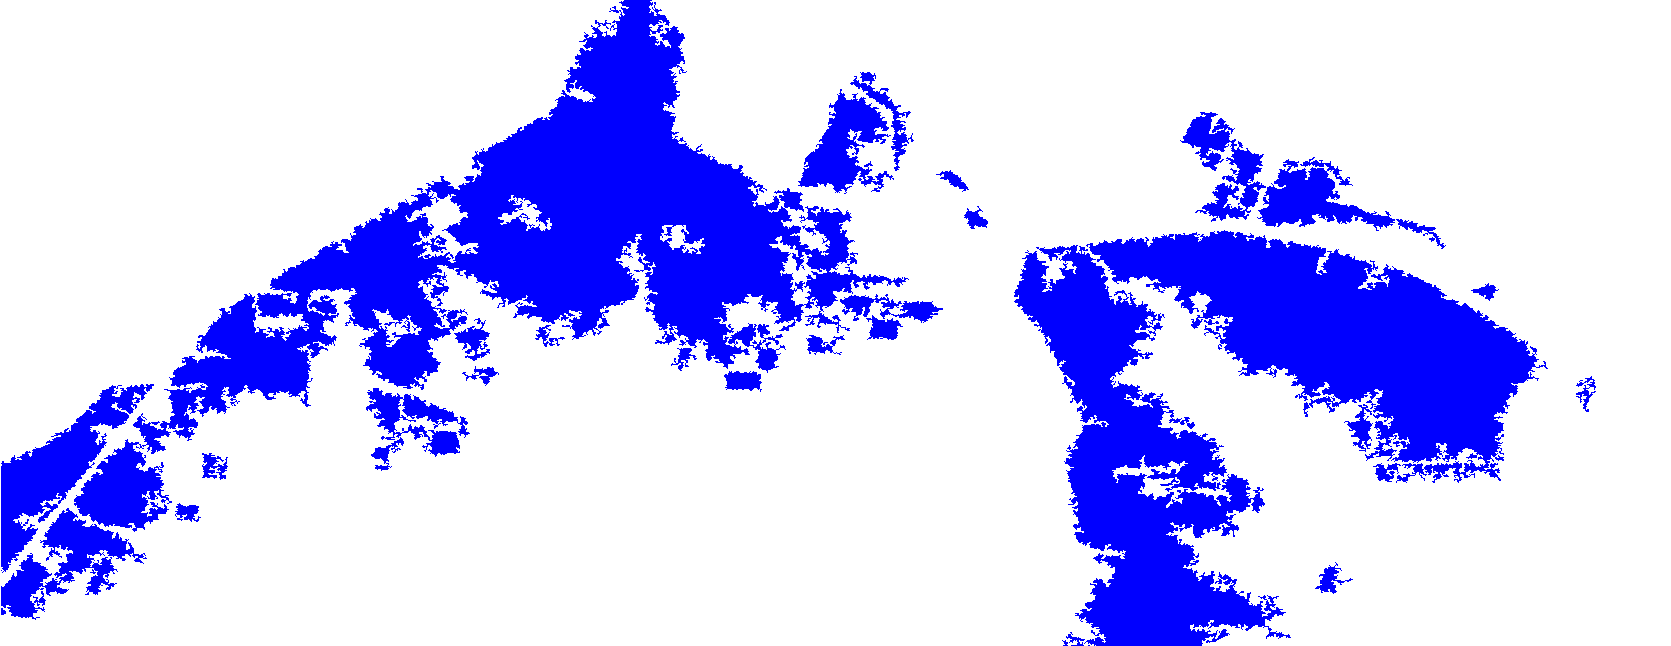

In [8]:
# Read AOI
aoi = gpd.read_file(app.geojson_S1)

# AOI bounds
left, bottom, right, top = aoi.total_bounds

# Define map bounds
map_bounds = [[bottom, left], [top, right]]

# Read flood image using AOI
flood_fpath = glob.glob(os.path.join(app.Results_dir, 'Flood_map_*.tif'))[0]
with rio.open(flood_fpath) as src:
    flood, out_transform = rasterio.mask.mask(src, aoi.geometry, crop=True)
    flood = flood[0,:,:]
    
# Create a map located to the AOI
m = folium.Map(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr = 'Esri',
    location=[aoi.centroid.y[0], aoi.centroid.x[0]],
    zoom_start=13)

# Add flood image to the map, flood background is transparent
raster_to_coloridx = {1: (0.0, 0.0, 1.0, 1.0),
                      0: (0.0, 0.0, 0.0, 0.0)}

# Show map
m.add_child(folium.raster_layers.ImageOverlay(flood, 
                                             opacity=0.5,
                                             bounds=map_bounds,
                                             colormap=lambda x: raster_to_coloridx[x]))
m

### <a id='search_download'></a> 4.2 Delineated Flooded Fields, characterized as Cultivated or Not-Cultivated

Preview flood-affected, cultivated (green) or not-cultivated (red), delineated fields. Fields are overlayed on an NDVI image, selected by minimum cloud coverage.

proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode



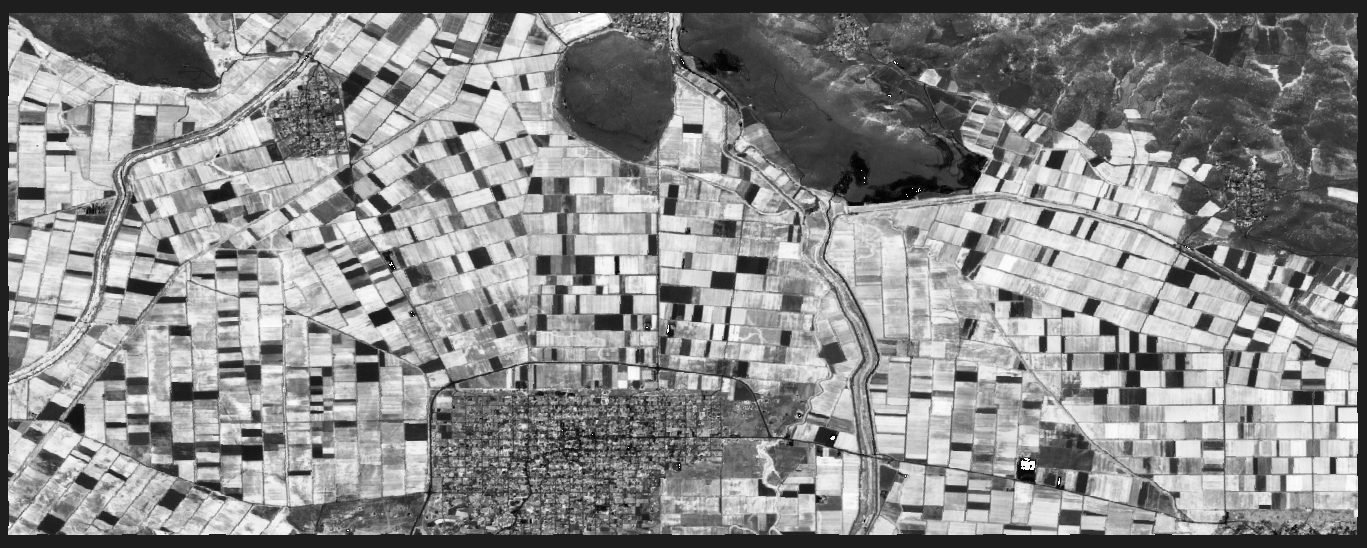

In [9]:
# Read NDVI image
ndvi, ndvi_bounds = wekeo_utils.ndvi_wgs84(app)

# Read vector delineated crop field boundaries
field_bounds_fpath = glob.glob(os.path.join(USER_DIR, app.projectname, 'Results_crop_delineation', 'flooded_fields__*.shp'))[0]
field_bounds = gpd.read_file(field_bounds_fpath)

# Change transformation to Geographic WGS'84
field_bounds = field_bounds.to_crs(4326)

# Create a map located to the AOI
m = folium.Map(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr = 'Esri',
    location=[aoi.centroid.y[0], aoi.centroid.x[0]],
    zoom_start=13)

# Add NDVI image to the map
m.add_child(folium.raster_layers.ImageOverlay(ndvi, bounds=ndvi_bounds))

# Add delineated flooded fields to map
def style_fn(feature):
    vector_to_coloridx = {
        'cultivated': {'fillColor':'#008000', 'fillOpacity':0.6, 'color':'#008000'},
        'not_cultivated': {'fillColor':'#FF0000', 'fillOpacity':0.6, 'color':'#FF0000'}
    }
    cultivation_status = feature['properties']['status']
    return vector_to_coloridx[cultivation_status]

m.add_child(folium.GeoJson(field_bounds.__geo_interface__, style_function=style_fn,))

# Add a Map Legend
template = wekeo_utils.template()
macro = MacroElement()
macro._template = Template(template)

# Show map
m.get_root().add_child(macro)
m

<div class="alert alert-block alert-warning">

### Challenge:
<font size="3"> We encourage the user to analyse more flood events by updating parameters in the configuration file located at the wekeo home directory: /home/your-user-name/FLOMPY/FLOMPYapp_template.cfg

More information regarding the configuration parameters can be found in the /home/your-user-name/FLOMPY/README.md file.
</font>

<div>